# Augmentator

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_aug_rt = global_run_tests
global_run_tests = False

%run visualisation.ipynb
%run dataset.ipynb

global_run_tests = _aug_rt

In [31]:
class Augmentator:
    _params = {
        'smooth'    : .8,
        'angle'     : 45,
        'brightness': .5,
        'inverse'   : .5,
        'contrast'  : [.25, 2.5],
    }
    
    def __init__(self, cache_size=100):
        self._cache      = dict()
        self._cache_size = cache_size
        
    def augment(self, im, use_cache=True, rate=1):
        if self._cache_size == 0:
            return im
        
        shape = im.shape
        w = shape[1]
        h = shape[0]
        if use_cache:
            hc = hash(im.tostring())
            cached = self._cache.get(hc, [])
            if len(cached) >= self._cache_size:
                return np.copy(cached[np.random.randint(self._cache_size)])
        im = np.copy(im)
            
        # smooth
        p = self._params['smooth']
        k = p*np.random.random(1)**2 * rate
        if k > 0.1:
            kernel = np.ones([5,5],np.float32)/25
            old= np.copy(im)
            im = cv2.filter2D(im,-1,kernel)
            im = np.reshape(im, shape)
            im = k*im + (1-k)*old

        # angle
        p = self._params['angle']
        k = np.random.uniform(-p, p) * rate
        b = np.mean(im[:10,:10])
        im[0,:]   = b
        im[h-1,:] = b
        im[:,0]   = b
        im[:,w-1] = b
        im = rotate(im, k, reshape=False, mode='nearest')
        
        # brightness
        p = self._params['brightness'] * rate
        k = np.random.uniform(1-p, 1+p)
        im = im * k
        im = np.minimum(im,1)
        im = np.maximum(im,0)

        # contrast
        p = self._params['contrast']
        k = rate*np.random.uniform(*p) + (1-rate)
        im = np.power(im, k)
            
        # inverse
        p = self._params['inverse'] * rate
        k = np.random.random(1)
        if k < p:
            im = 1-im        
            
        # bounding
        assert np.all(im<=1)
        assert np.all(im>=0)

        # cache
        if use_cache:
            cached.append(im)
            self._cache[hc] = cached
        return im    

## Test augmentation

Original:


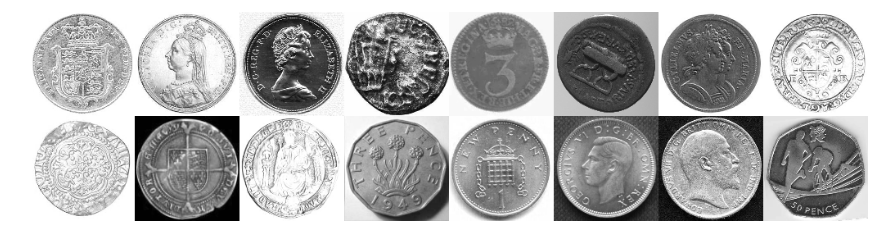

Augmented:


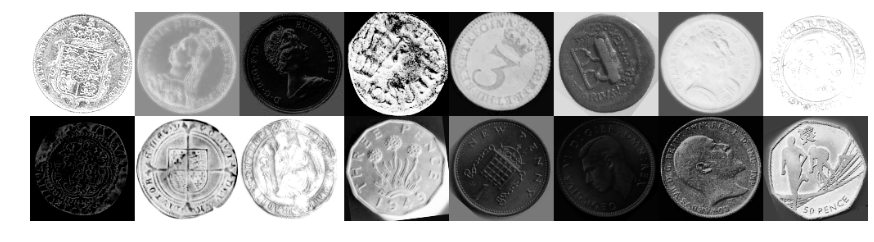

In [32]:
def test_augmentation(path, data_size):
    data = Dataset(image_shape=[128, 128, 1])
    aug  = Augmentator()
    data.load(path, data_size)

    train_images = data.train_images
    image_shape  = data.image_shape
    augment      = aug.augment

    n = 16
    s = np.random.randint(data_size-n)
    im1 = train_images[s:s+n]
    im2 = np.copy(im1)
    for i in range(n):
        im2[i] = augment(im2[i], use_cache=False, rate=1)
    print("Original:")
    show_images(im1, image_shape, cols=n//2, rows=2)
    print("Augmented:")
    show_images(im2, image_shape, cols=n//2, rows=2)

if global_run_tests:
    test_augmentation(_dataset_path, 100)

## Test augmented batching

path     : /netforge/datasets/private/roman/coins/images
data_size: 100
['       0', '       0', '       1', '       1', '       1', '       0', '       1', '       1']


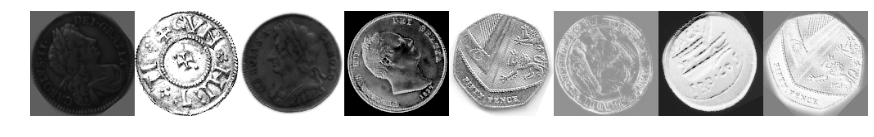

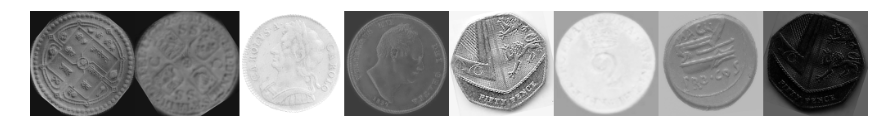

In [34]:
if global_run_tests:
    test_batching(_dataset_path, 100, augment=Augmentator().augment)